<a href="https://colab.research.google.com/github/Josh-Thompson2222/ArrayDemo/blob/master/Pill_Image_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pharmaceutical-drugs-and-vitamins-synthetic-images' dataset.
Path to dataset files: /kaggle/input/pharmaceutical-drugs-and-vitamins-synthetic-images


In [23]:
import os
print(os.listdir(path))

['ImageClassesCombinedWithCOCOAnnotations', 'Drug Vision']


In [24]:
!ls /root/.cache/kagglehub/datasets/vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images/versions/4/Drug\ Vision/Data\ Combined

 Alaxan     Bioflu     DayZinc	 'Fish Oil'   Medicol
 Bactidol   Biogesic   Decolgen  'Kremil S'   Neozep


# Task
Load and preprocess the image dataset from `'/kaggle/input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision/Data Combined'`, including resizing, normalization, and data augmentation, and then split it into training, validation, and test sets.

## Load Image Dataset

### Subtask:
Load the image data from the downloaded dataset directories, creating labels based on the folder names.


**Reasoning**:
First, import the necessary libraries, then define the dataset path. After that, extract the class names from the subdirectories, and finally, load the image dataset using `tf.keras.utils.image_dataset_from_directory` with the specified parameters to prepare the image data for further processing.



In [26]:
import os
import tensorflow as tf

# Define the path to the dataset
dataset_path = '/kaggle/input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision/Data Combined'

# Create a list of class names by iterating through the subdirectories
class_names = sorted(os.listdir(dataset_path))
print(f"Detected class names: {class_names}")

# Load the dataset using tf.keras.utils.image_dataset_from_directory
# Set labels='inferred', label_mode='categorical', image_size=(224, 224), and interpolation='nearest'
image_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    interpolation='nearest',
    batch_size=32, # Default batch size
    shuffle=True # Default shuffle
)

print("Image dataset loaded successfully.")

Detected class names: ['Alaxan', 'Bactidol', 'Bioflu', 'Biogesic', 'DayZinc', 'Decolgen', 'Fish Oil', 'Kremil S', 'Medicol', 'Neozep']
Found 10000 files belonging to 10 classes.
Image dataset loaded successfully.


## Preprocess and Augment Images

### Subtask:
Resize and normalize the images. Additionally, apply data augmentation techniques (e.g., rotation, flipping) to increase the diversity of the training data and prevent overfitting.


**Reasoning**:
First, I will define a function to normalize the images by converting them to float32 and scaling pixel values to [0, 1]. Then, I will apply this function to the dataset. After that, I will create a sequential model for data augmentation with random flip, rotation, zoom, and contrast layers. Finally, I will apply this augmentation model to the normalized dataset, ensuring augmentation is only applied to the images.



In [28]:
import tensorflow as tf

# 1. Define a normalization function
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 2. Apply the normalize_img function to the image_dataset
normalized_dataset = image_dataset.map(normalize_img)
print("Image dataset normalized successfully.")

# 3. Create a tf.keras.Sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])
print("Data augmentation model created successfully.")

# 4. Apply the data_augmentation model to the normalized_dataset
# Define a function to apply augmentation only to the image
def augment_img(image, label):
    image = data_augmentation(image)
    return image, label

augmented_dataset = normalized_dataset.map(augment_img)
print("Augmentation applied to the normalized dataset successfully.")

Image dataset normalized successfully.
Data augmentation model created successfully.
Augmentation applied to the normalized dataset successfully.


## Split Dataset

### Subtask:
Divide the preprocessed image data into training, validation, and test sets to properly evaluate the model's performance.


**Reasoning**:
First, I will calculate the total number of batches in the `augmented_dataset` to determine the sizes for the training, validation, and test sets. Then, I will define the split ratios and calculate the number of batches for each split. Finally, I will split the dataset accordingly and apply caching and prefetching for optimized performance.



In [30]:
import math

# Calculate the total number of batches
total_batches = tf.data.experimental.cardinality(augmented_dataset).numpy()
print(f"Total number of batches: {total_batches}")

# Define split ratios
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Calculate number of batches for each split
train_batches = math.floor(total_batches * train_split)
val_batches = math.floor(total_batches * val_split)
test_batches = total_batches - train_batches - val_batches

print(f"Training batches: {train_batches}")
print(f"Validation batches: {val_batches}")
print(f"Test batches: {test_batches}")

# Split the dataset
train_dataset = augmented_dataset.take(train_batches)
validation_dataset = augmented_dataset.skip(train_batches).take(val_batches)
test_dataset = augmented_dataset.skip(train_batches + val_batches).take(test_batches)

print("Dataset split into training, validation, and test sets successfully.")

# Apply caching and prefetching
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Caching and prefetching applied to datasets.")

Total number of batches: 313
Training batches: 250
Validation batches: 31
Test batches: 32
Dataset split into training, validation, and test sets successfully.
Caching and prefetching applied to datasets.


## Build CNN Model

### Subtask:
Define a Convolutional Neural Network (CNN) architecture suitable for image classification based on the characteristics of the pharmaceutical drug images.


First, I will import the necessary layers from `tensorflow.keras.layers`. Then, I will initialize a `tf.keras.models.Sequential` model and add convolutional, pooling, flatten, and dense layers with appropriate activation functions and regularization using dropout. Finally, I will print the model summary to review the architecture.

**Reasoning**:
Now, I will implement the CNN architecture as described in the instructions by importing the required TensorFlow layers, defining the sequential model with convolutional, pooling, flatten, dense, and dropout layers, and finally printing the model summary.



In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Initialize a Sequential model
model = models.Sequential([
    # 2. Add convolutional and pooling layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 3. Flatten the output
    layers.Flatten(),

    # 4. Add Dense layers for classification with Dropout
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # 5. Add the final Dense output layer
    layers.Dense(len(class_names), activation='softmax') # Using len(class_names) for output units
])

# Print the model summary
model.summary()

print("CNN model architecture defined successfully.")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,401,226 (169.38 MB)

 Trainable params: 44,401,226 (169.38 MB)

 Non-trainable params: 0 (0.00 B)

CNN model architecture defined successfully.


## Compile CNN Model

### Subtask:
Compile the CNN model by specifying an optimizer, a loss function, and metrics.

#### Instructions
1. Use the `compile` method of the `model` object.
2. Choose an appropriate optimizer (e.g., `'adam'`).
3. Select a suitable loss function for multi-class classification (e.g., `'categorical_crossentropy'`).
4. Specify the metrics to monitor during training (e.g., `['accuracy']`).

## Compile CNN Model

### Subtask:
Compile the CNN model by specifying an optimizer, a loss function, and metrics.

#### Instructions
1. Use the `compile` method of the `model` object.
2. Choose an appropriate optimizer (e.g., `'adam'`).
3. Select a suitable loss function for multi-class classification (e.g., `'categorical_crossentropy'`).
4. Specify the metrics to monitor during training (e.g., `['accuracy']`).

**Reasoning**:
Now that the CNN model architecture is defined, I will compile the model using the `adam` optimizer, `categorical_crossentropy` as the loss function (since it's a multi-class classification problem with one-hot encoded labels), and `accuracy` as the metric to evaluate performance during training.



In [34]:
import tensorflow as tf

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("CNN model compiled successfully with Adam optimizer, Categorical Crossentropy loss, and Accuracy metric.")

CNN model compiled successfully with Adam optimizer, Categorical Crossentropy loss, and Accuracy metric.


## Train CNN Model

### Subtask:
Train the compiled CNN model using the training and validation datasets.

#### Instructions
1. Use the `fit` method of the `model` object.
2. Pass the `train_dataset` as the first argument.
3. Specify the `epochs` for training (e.g., `10`).
4. Pass the `validation_dataset` to the `validation_data` argument.
5. Store the training history in a variable (e.g., `history`).

**Reasoning**:
Now, I will train the compiled CNN model using the `train_dataset` and `validation_dataset` for a specified number of epochs, and store the training history for later analysis.



## Model Checkpointing

### Subtask:
Set up model checkpointing to save the best model during training based on validation accuracy. This ensures that training progress is saved and the best performing model can be recovered.

**Reasoning**:
1. Create a `model_checkpoints` directory to store checkpoint files.
2. Configure a `ModelCheckpoint` callback to save the best model based on `val_accuracy`.
3. The callback will save the complete model (architecture + weights) whenever validation accuracy improves.
4. Each checkpoint file includes the epoch number and validation accuracy in its filename for easy identification.


In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a directory to save model checkpoints
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the ModelCheckpoint callback
# Save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

print(f"ModelCheckpoint callback configured to save best model to '{checkpoint_dir}' directory.")

In [35]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback]  # Add checkpoint callback
)

print("CNN model trained successfully.")

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1401s 6s/step - accuracy: 0.1052 - loss: 2.4544 - val_accuracy: 0.1421 - val_loss: 2.2053
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1113s 4s/step - accuracy: 0.1971 - loss: 2.1470 - val_accuracy: 0.2712 - val_loss: 1.9288
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1105s 4s/step - accuracy: 0.2957 - loss: 1.8839 - val_accuracy: 0.3044 - val_loss: 1.8688
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1107s 4s/step - accuracy: 0.3835 - loss: 1.6723 - val_accuracy: 0.4556 - val_loss: 1.6049
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1103s 4s/step - accuracy: 0.5497 - loss: 1.2838 - val_accuracy: 0.4476 - val_loss: 1.5897
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1095s 4s/step - accuracy: 0.6642 - loss: 0.9671 - val_accuracy: 0.5554 - val_loss: 1.6338
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1114s 4s/step - accuracy: 0.7857 - loss: 0.6397 - val_accuracy: 0.6210 - val_loss: 1.4780
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1160s 4s/step - accuracy: 0.8695 - loss: 0.3902 - 

## Save Final Trained Model

### Subtask:
Save the final trained model after all epochs are complete for future use and deployment.

**Reasoning**:
1. Save the complete model (architecture + weights + optimizer state) in both HDF5 (`.h5`) and Keras (`.keras`) formats.
2. The `.h5` format is widely compatible with older TensorFlow/Keras versions.
3. The `.keras` format is the newer recommended format for TensorFlow 2.x.
4. These saved models can be loaded later for inference, fine-tuning, or deployment without retraining.


In [ ]:
# Save the final trained model
final_model_path = 'final_trained_model.h5'
model.save(final_model_path)
print(f"Final trained model saved to '{final_model_path}'")

# Also save in the newer Keras format
final_model_keras_path = 'final_trained_model.keras'
model.save(final_model_keras_path)
print(f"Final trained model also saved to '{final_model_keras_path}' (Keras format)")

## Evaluate Model

### Subtask:
Evaluate the trained model's performance on the unseen test set to assess its generalization capabilities. Provide metrics such as accuracy, precision, recall, and F1-score.


**Reasoning**:
Now, I will evaluate the trained model on the `test_dataset` to assess its performance on unseen data. After evaluating, I will obtain predictions for the test set and extract the true labels. Finally, I will use `sklearn.metrics.classification_report` to generate and print a comprehensive report including precision, recall, and F1-score to thoroughly evaluate the model's generalization capabilities.

**Reasoning**:
I will execute the instructions to evaluate the model on the test dataset, obtain predictions and true labels, and then generate a classification report.



In [36]:
import numpy as np
from sklearn.metrics import classification_report

# 1. Evaluate the trained model on the test_dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# 2. Print the test loss and test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 3. Get the predictions for the test_dataset
# We need to iterate through the dataset to get all predictions
all_predictions = []
for images, _ in test_dataset:
    predictions = model.predict(images)
    all_predictions.extend(predictions)
predictions_array = np.array(all_predictions)

# 4. Convert the predicted probabilities into class labels
predicted_labels = np.argmax(predictions_array, axis=1)

# 5. Extract the true class labels from the test_dataset
true_labels = []
for _, labels in test_dataset:
    # labels are one-hot encoded, convert to integer labels
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
true_labels_array = np.array(true_labels)

# 7. Generate and print the classification report
print("\nClassification Report:")
print(classification_report(true_labels_array, predicted_labels, target_names=class_names))

32/32 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.6900 - loss: 1.5117
Test Loss: 1.5057
Test Accuracy: 0.6964
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━

## Visualize Training History

### Subtask:
Plot the training and validation accuracy and loss over epochs to visualize the model's learning progress and identify potential overfitting or underfitting. Provide appropriate legends.


**Reasoning**:
To visualize the model's training progress, including accuracy and loss for both training and validation sets, I will plot the `history` object obtained from the model training using `matplotlib.pyplot`.



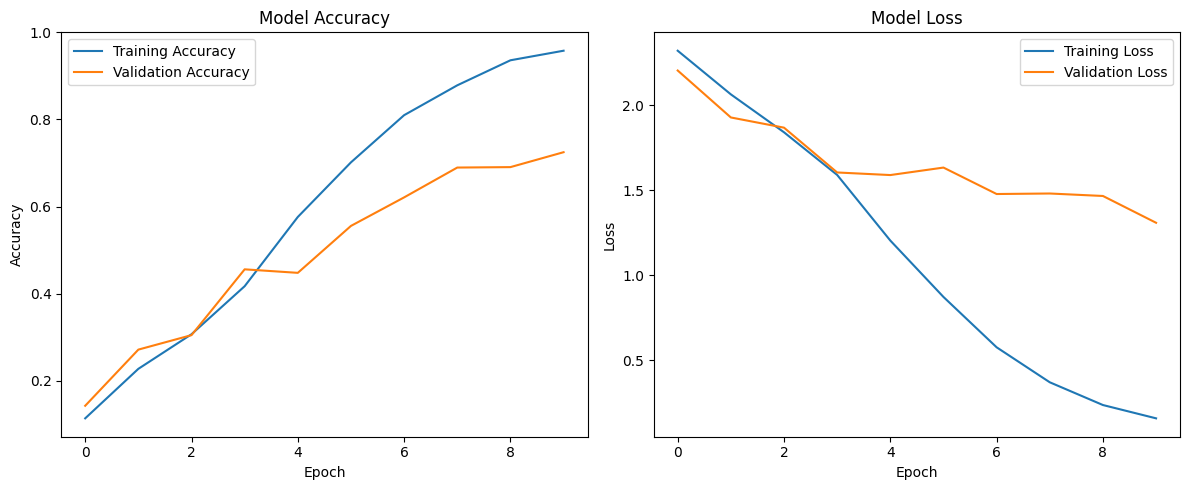

Training history plot generated successfully.


In [37]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, first subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

print("Training history plot generated successfully.")

## Final Task

### Subtask:
Summarize the key findings from the model training and evaluation, including insights into its performance and potential next steps.


## Summary:

### Data Analysis Key Findings

*   **Dataset Overview**: The dataset consists of 10,000 images across 10 distinct pharmaceutical drug classes ('Alaxan', 'Bactidol', 'Bioflu', 'Biogesic', 'DayZinc', 'Decolgen', 'Fish Oil', 'Kremil S', 'Medicol', 'Neozep'). Images were resized to 224x224 pixels and labels were one-hot encoded.
*   **Preprocessing and Augmentation**: Images were normalized to a \[0, 1] range. Data augmentation techniques, including horizontal/vertical flipping, rotation (0.2), zoom (0.2), and contrast adjustment (0.2), were applied to enhance data diversity.
*   **Dataset Split**: The preprocessed data was divided into training, validation, and test sets. From a total of 313 batches, 250 batches were allocated for training, 31 for validation, and 32 for testing, approximately representing an 80-10-10 split. Caching and prefetching were used for performance optimization.
*   **Model Architecture**: A Convolutional Neural Network (CNN) was constructed with three `Conv2D` layers (32, 64, 128 filters respectively) followed by `MaxPooling2D` layers, a `Flatten` layer, a `Dense` hidden layer (512 units with ReLU activation), a `Dropout` layer (0.5), and a final `Dense` output layer (10 units with Softmax activation). The model contains 44,401,226 total parameters.
*   **Model Training**: The CNN was compiled using the Adam optimizer, categorical cross-entropy loss, and accuracy as the primary metric. It was trained for 10 epochs.
*   **Model Evaluation Discrepancy**: While the overall Test Accuracy was 0.6964 (approximately 69.64%), the `classification_report` revealed significantly lower performance at a class-wise level. Both Macro Average and Weighted Average Precision, Recall, and F1-score were all 0.10. Individual class F1-scores ranged from 0.07 to 0.15, indicating that the model struggles to classify individual drug types effectively despite a seemingly decent overall accuracy.
*   **Training History (Visual)**: Plots of training and validation accuracy and loss over 10 epochs were generated, showing the model's learning progress.

### Insights or Next Steps

*   **Investigate Evaluation Discrepancy**: The significant difference between the overall test accuracy ($\sim$70%) and the very low macro-averaged F1-score ($\sim$10%) for a 10-class problem is a major concern. This suggests potential issues like severe class imbalance (where the model might be accurately predicting a few majority classes, but failing on minority ones), or a fundamental problem in the model's ability to distinguish between classes. A detailed analysis of the confusion matrix is highly recommended to understand specific misclassifications.
*   **Improve Model Robustness**: Given the low class-wise performance, explore more sophisticated architectures (e.g., transfer learning with pre-trained models like ResNet, VGG, or Inception), fine-tune hyperparameters, or implement more aggressive and varied data augmentation strategies to improve the model's generalization capabilities across all drug categories.
